In [21]:
import torch

from utils import load_model
from models.unet import UNet

import json
from matplotlib import pyplot as plt
import cv2
import numpy as np


In [7]:
run_name = "2023-11-08_11-46-11"

run_path = f"runs/{run_name}/"

In [8]:
train_summary = json.load(open(run_path + "train_summary.json"))

model_name = train_summary["config"]["MODEL"]
IMAGE_SIZE = train_summary["config"]["IMAGE_SIZE"]

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
if model_name == "UNet":
    model = UNet(outSize=(IMAGE_SIZE, IMAGE_SIZE)).to(DEVICE)
else:
    raise NotImplementedError

model = load_model(model, run_path + "best_model.pth")

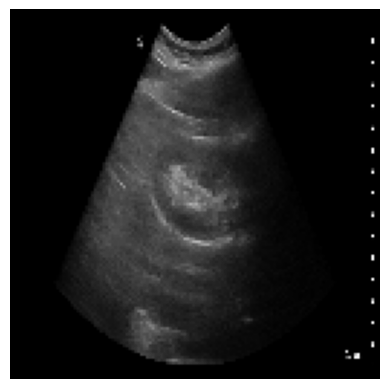

In [18]:
img_path = "datasets/test_kidney.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

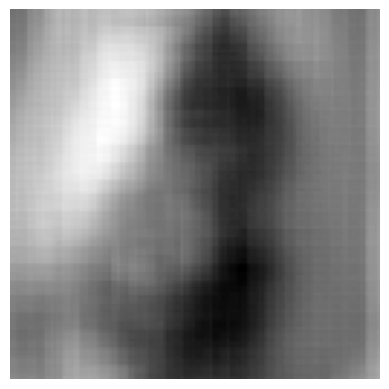

In [20]:
with torch.no_grad():
    model.eval()
    img_tensor = torch.tensor(img / 255).unsqueeze(0).unsqueeze(0).float().to(DEVICE)
    pred = model(img_tensor)
    pred = pred.squeeze().cpu().numpy()

# Thresholding
# pred = pred > 0.5

plt.imshow(pred, cmap="gray")
plt.axis("off")
plt.show()